# Explicability of the best model
- Author: Francisco Martínez García

In this notebook, the chosen model (Random Forest) will be optimized. Then we will study its explicability and understand what the model takes into account in order to make its decisions

# Library

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pickle
import matplotlib.pyplot as plt
import matplotlib
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import confusion_matrix # Matriz confusion
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve, fbeta_score
from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import re

import shap
import functions as fx

# Upload data

In [11]:
#Read the traing data
pd_train = pd.read_parquet('../data/training_data.parquet')
pd_test = pd.read_parquet('../data/test_data.parquet')

#Obtain thre same training data as in the previous steps
X_train, X_validation, y_train, y_validation = train_test_split(pd_train, pd_train['isFraud'], 
                                                                test_size=0.15, 
                                                                random_state=1)
X_train = X_train.drop(['isFraud'], axis=1)
#Divide test data in x and y
X_test = pd_test.drop(['isFraud'], axis=1)
y_test = pd_test['isFraud']

In [4]:
X_train.head()

,step,type_1,type_2,type_3,type_4,type_5,amount,device_1,device_2,device_3,...,zone_1,zone_2,zone_3,zone_4,user_number,user_connections,security_alert_1,security_alert_2,oldbalanceDest,newbalanceDest
1087549,72,0,1,0,0,0,21499.025105,0,0,0,...,0,0,0,0,2800,3,0,1,0.000000,0.000000
1671002,83,0,1,0,0,0,457778.683849,0,0,0,...,0,0,0,0,521,5,0,1,0.000000,0.000000
1522046,31,0,0,1,0,0,523081.675986,0,0,0,...,0,0,0,0,1428,3,0,1,26409.903665,549491.579651
196365,45,0,0,1,0,0,64045.470000,0,0,0,...,1,0,0,0,4031,7,0,1,390618.710000,454664.180000
185771,12,0,0,1,0,0,159950.860000,1,0,0,...,1,0,0,0,629,1,0,1,54121.730000,214072.600000


# Optimization

In [12]:
with open('../models/preprocessor.pickle', 'rb') as f:
    preprocessor = pickle.load(f)

In [4]:
rf = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('clasificador', RandomForestClassifier())])

### Parameter Tunning Optimization
param_grid = { 
    'clasificador__n_estimators': [100, 150, 400],
    'clasificador__max_features': ['sqrt', 'log2'],
    'clasificador__max_depth' : [4, 6, 8, None],
    'clasificador__criterion' :['gini'],
    'clasificador__class_weight':['balanced']}


CV = GridSearchCV(rf, param_grid, cv=2, n_jobs=5, scoring='roc_auc', verbose=1)

In [5]:
CV.fit(X_train, y_train)
print(CV.best_params_)
print(CV.best_score_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
{'clasificador__class_weight': 'balanced', 'clasificador__criterion': 'gini', 'clasificador__max_depth': 8, 'clasificador__max_features': 'sqrt', 'clasificador__n_estimators': 400}
0.9917244906175173


In [6]:
with open('../models/Final_RandomForest.pickle', 'wb') as f:
    pickle.dump(CV, f)

In [13]:
# Para no tener que ejecutar, saltarse el fit y ejecutar a partir de aquí
with open('../models/Final_RandomForest.pickle', 'rb') as f:
    CV = pickle.load(f)

In [5]:
print(CV.best_params_)
print(CV.best_score_)
ypred = CV.predict(X_test)

{'clasificador__class_weight': 'balanced', 'clasificador__criterion': 'gini', 'clasificador__max_depth': 8, 'clasificador__max_features': 'sqrt', 'clasificador__n_estimators': 400}
0.9917244906175173


In [6]:
ypred_proba = CV.predict_proba(X_test)

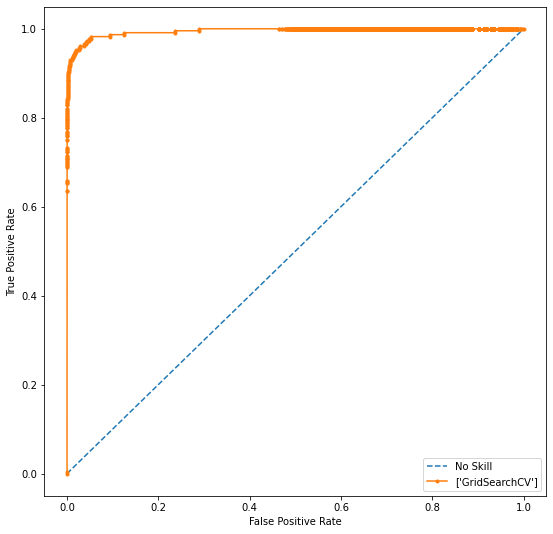

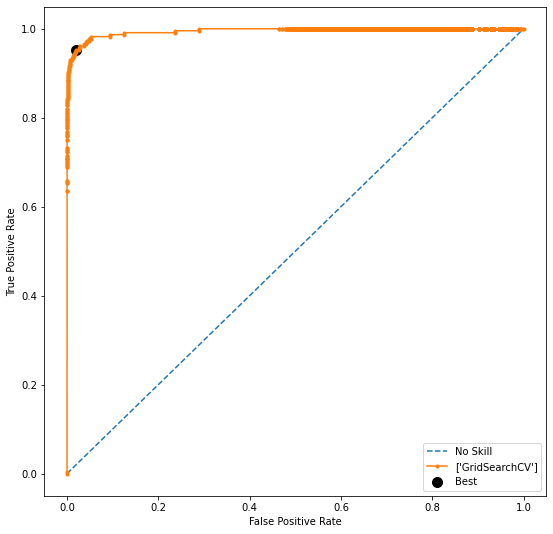

ROC-AUC score of the model: 0.9948920123084304
Accuracy of the model: 0.9802636911999618

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    209487
           1       0.05      0.95      0.09       228

    accuracy                           0.98    209715
   macro avg       0.52      0.96      0.54    209715
weighted avg       1.00      0.98      0.99    209715


Confusion matrix: 
[[205360   4127]
 [    12    216]]

F2 Score: 
0.59484224279566



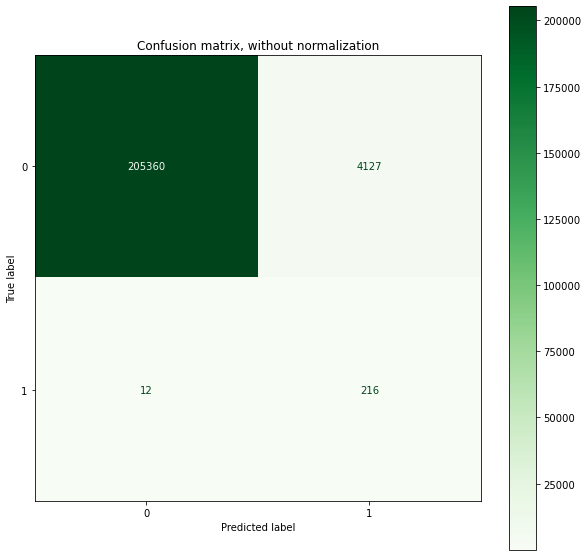

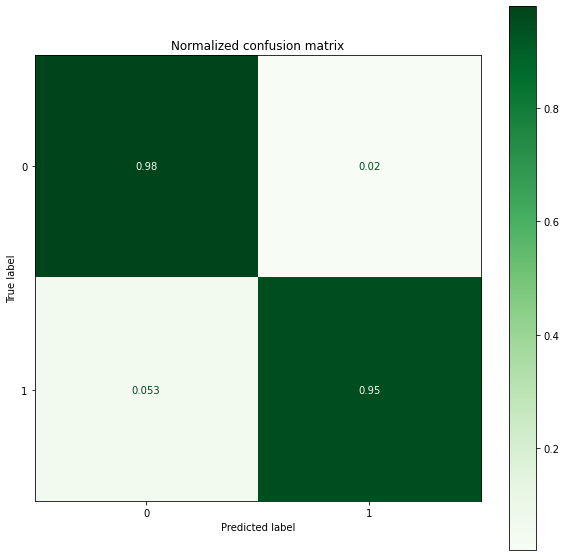

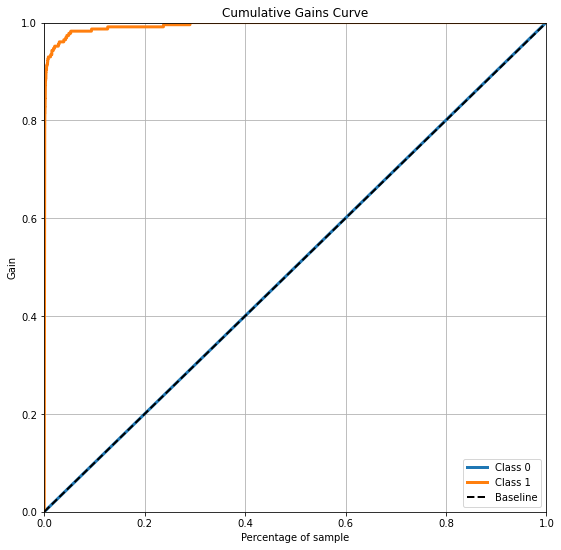

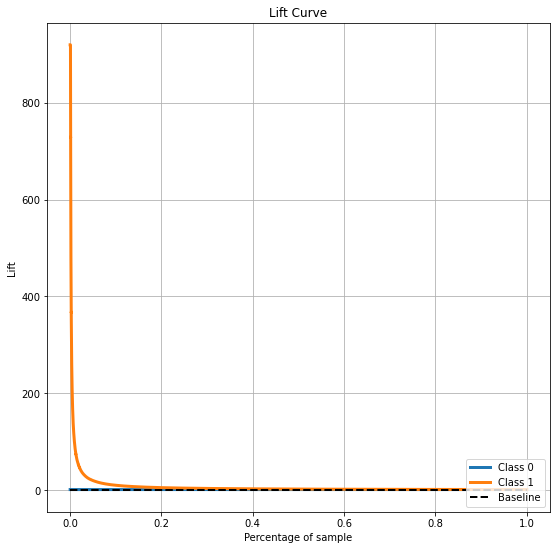

In [6]:
fx.model_analysis_op(CV, X_test, y_test)

### Threshold setting prediction

In [19]:
# keep probabilities for the positive outcome only
yhat = ypred_proba[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

ypred_new_threshold = (ypred_proba[:,1]>thresholds[ix]).astype(int)
evaluate_model(y_test,ypred_new_threshold,ypred_proba)

Best Threshold=0.459547, G-Mean=0.966
ROC-AUC score of the model: 0.9948920123084304
Accuracy of the model: 0.9802636911999618

Classification report: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    209487
           1       0.05      0.95      0.09       228

    accuracy                           0.98    209715
   macro avg       0.52      0.96      0.54    209715
weighted avg       1.00      0.98      0.99    209715


Confusion matrix: 
[[205360   4127]
 [    12    216]]

F2 Score: 
0.59484224279566



# Explication

### Partial Dependence Plot

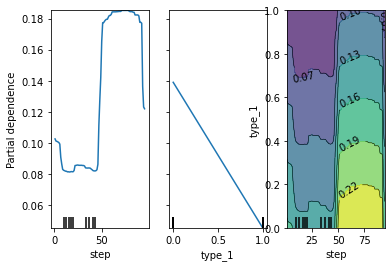

In [22]:
from sklearn.inspection import PartialDependenceDisplay
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(CV, X_train, features)

## Shap

The library Shap will be used to give an explanation the the results obtained with the optimized model, and understand its decisions.

In [14]:
#Create model
shap.initjs()
model = CV.best_estimator_.named_steps['clasificador']
explainer = shap.TreeExplainer(model)

In [31]:
#Execute model
shap_values = explainer.shap_values(X_test)

In [32]:
#Save model
with open('../models/shap_values.pickle', 'wb') as f:
    pickle.dump(shap_values, f)

In [15]:
#Load model
with open('../models/shap_values.pickle', 'rb') as f:
    shap_values = pickle.load(f)

In [16]:
base_value = explainer.expected_value

### Summary Plot polarized

The summary plot below give us a global vision of the conclusions obtained by the model. As it is appreciated in the visualization. The type of transaction(type_1, type_3, type_5 especially) is a very important factor, as it is shown that depending on its value (color red or blue) affects the model in a different manner.

Furthermore, the old and new balance of both origin and destiny are important factors as well. 

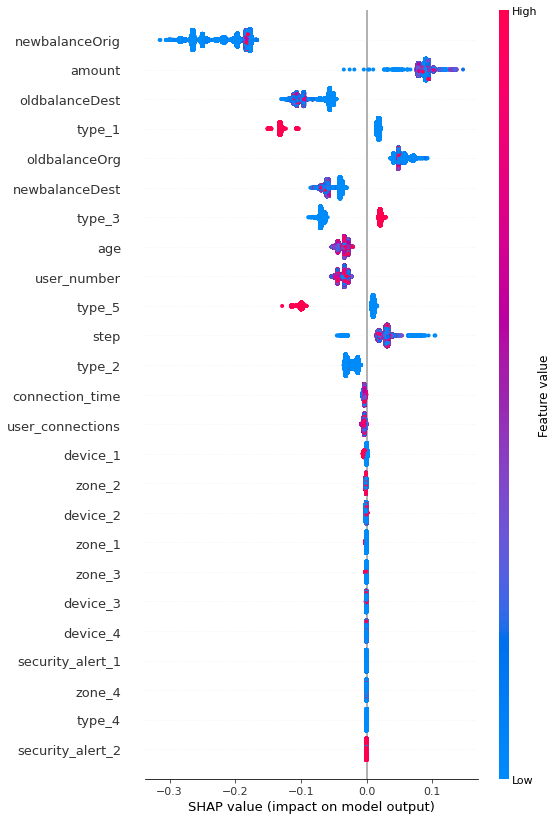

In [37]:
shap.summary_plot(shap_values[1], features=X_test, max_display=25)

### Summary plot

The following plot gives us the most important variables for this case too. As it is shown, the balances of the accounts, the amounts and the type are the most crutial ones

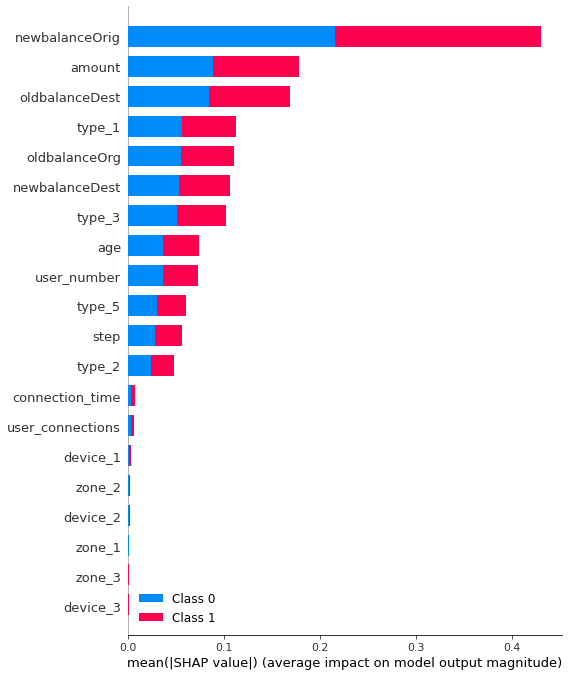

In [36]:
shap.summary_plot(shap_values, X_test)

### Local explicability

This graph shows us the results of the prediction for a specific linen in this case, line 21. It obtained 0.2 of probability of being a fraud. The new balance origin and old balance destiny are the biggest factors to decrease this probability. On the other hand, the amount of the transaction increases its probability, as well as the old balance of the origin

In [17]:
#One line explained
shap.force_plot(explainer.expected_value[0], shap_values[1][20], X_test.iloc[20,:])